# Transfer Learning and basic fine-tuning using VGG16 for Pneumonia classification

Using VGG16 pre-trained model to predict whether an X-ray scan shows presence of pneumonia.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset

In this notebook, you will try two ways to customize a pretrained model:

1.  Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

    You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

2.  Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1.  Examine and understand the data
2.  Build an input pipeline, in this case using Keras ImageDataGenerator
3.  Compose the model
    - Load in the pretrained base model (and pretrained weights)
    - Stack the classification layers on top
6.  Train the model
7.  Evaluate model


# Getting Setup

## Import Packages


In [1]:
# import necessary packages
import os
import warnings
import math
import pandas as pd
import numpy as np
import PIL
from numpy.random import seed
from datetime import datetime
from scipy import interp
from itertools import cycle
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import (
    save_model, 
    load_model
)
# for deep learning
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    load_img,
    img_to_array
)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, AUC
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import Sequential
from tensorflow.keras.layers import(
    Dense,
    Dropout,
    GlobalAveragePooling2D,
    Flatten,
    BatchNormalization,
)

from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    LearningRateScheduler,
    Callback,
    TensorBoard,
)
# for metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    plot_confusion_matrix, 
    auc,
    roc_auc_score,
    roc_curve,
)

# ignore warnings
warnings.filterwarnings("ignore")
print("[INFO] All required packages are ready...")


[INFO] All required packages are ready...


### Check for GPU Access

In [2]:
# check TF vesion
print("Tensorflow version: ", tf.__version__)

# check if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

if len(physical_devices) == 0:
    print("GPU device not found. Running on CPU.")
else:
    print('Found GPU at: {}'.format(physical_devices))


Tensorflow version:  2.4.1
Num GPUs: 1
Found GPU at: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Set Reproducibility Seed

In [3]:
# Reproducibility


def set_seed(seed=34):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    

print("[INFO] Reproducubilities are ready...")
set_seed(34)


[INFO] Reproducubilities are ready...


### Mount Google Drive

In [4]:
# mount google drive
# from google.colab import drive

# drive.mount('/content/drive')


### Set Working Directory

In [5]:
import sys

# set working directory for kaggle
path = '../input/labeled-chest-xray-images'
sys.path.insert(0, path)
print("[INFO]  Working directory path is set up...")

# set working directory for google colab
# path = '/content/drive/MyDrive/Colab Notebooks'
# sys.path.insert(0, path)
# print("[INFO]  Working directory path is set up...")


[INFO]  Working directory path is set up...


### Pull Data from Kaggle and Extract it

In [6]:
# download data from kaggle api
# !pip install -q kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d "tolgadincer/labeled-chest-xray-images" -p "~/workspace/ml-apps/input/"


In [7]:
# from utils.unzip_file import unzip_file

# # path where our data resides
# file_path = '/content/drive/MyDrive/input/chest_xray.zip'

# # for google colab
# unzip_file(file_path)
# print("[INFO]  Data has been unzipped...")


# Load Data

In [8]:
# set kaggle image data directories
MAIN_DIR =  "../input/labeled-chest-xray-images/chest_xray"
TRAIN_DIR = os.path.join(MAIN_DIR, 'train')
TEST_DIR = os.path.join(MAIN_DIR, 'test')

# look into train folder for .jpg files for normal and pneumonia images
NORMAL_TRAIN_IMAGES = os.path.join(MAIN_DIR, "train/NORMAL/")
PNEUMONIA_TRAIN_IMAGES = os.path.join(MAIN_DIR, "train/PNEUMONIA/")

# look into train folder for .jpg files for normal and pneumonia images
NORMAL_TEST_IMAGES = os.path.join(MAIN_DIR, "NORMAL")
PNEUMONIA_TES_IMAGES = os.path.join(MAIN_DIR, "PNEUMONIA")

print("[INFO] Data directories are ready...")


[INFO] Data directories are ready...


In [9]:
# print some image file names
train_normal_names = os.listdir(NORMAL_TRAIN_IMAGES)
print(train_normal_names[:3])


['NORMAL-705219-0001.jpeg', 'NORMAL-9031828-0001.jpeg', 'NORMAL-9211217-0001.jpeg']


In [10]:
# let's verify we have two classes
classes = os.listdir(TRAIN_DIR)
num_classes = len(classes)
print('Number of classes: ', num_classes)


Number of classes:  2


## Data Preprocessing and Use Data Augmentation

In order to avoid an overfitting problem, we need to expand our dataset artificially.
We can make this X-ray mages even larger. The idea is to alter the training data with small transformations to reproduce some variations. 

Data augmentatation technique will occur on the **training data** in ways that change the array representation while keeping the label the same.  Some popular augmentations are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.  By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

We can use in-place data augmentation or on-the-fly data augmentation.  We call this “in-place” and “on-the-fly” data augmentation because this augmentation is done at training time.

**Note**: For this model, data augmentation is included but at minimum because Medical X-ray scans are only taken in a specific orientation, and variations such as flips and rotations will not exist in real X-ray images.


### Set Hyperparameter, Metrics and other variables

In [11]:
# set a seed for data generators
data_seed = 1

# set class labels 
class_names = ['NORMAL', 'PNEUMONIA'] 

# set our image size
image_size = (224, 224)

# Initiate an input layer to pass our image size
input_shape = image_size + (3, )

# hyperparameter
batch_size = 32
epochs = 20
learning_rate = 1e-4

# optimizer 
opt = Adam(
    learning_rate=learning_rate,
    amsgrad=False,
    name='Adam',
)

# metrics
METRICS = [
    'accuracy',
    AUC(name='auc'),
    AUC(name='prc', curve='PR'), # precision-recall curve
    
]

metrics = METRICS

# define loss
loss = ['binary_crossentropy']


## Generate data batches for train/test images

In [12]:
# Generate batches of tensor image data with real-time data augmentation
# Takes the path to a directory & generates batches of augmented data


def get_train_generator(
    dir_path, image_size, batch_size, class_names, seed, shuffle=True
):
    """
    Initiating data augment generator that rescale and resizes.
    Scale all pixel intensities to the range [0, 1].
    """
    # initialize the training data augmentation object
    datagen_train = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.2,
    )

    # initialize the training generator
    train_generator_ = datagen_train.flow_from_directory(
        directory=dir_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode="binary",
        classes=class_names,
        seed=seed,
        shuffle=shuffle,
    )

    return train_generator_



def get_test_generator(
    dir_path, image_size, batch_size, class_names, seed, shuffle=False
):
    """
    initiating data augment generator that rescale and resizes.
    Scale all pixel intensities to the range [0, 1].
    """
    # initialize the training data augmentation object
    datagen_test = ImageDataGenerator(
        rescale=1./255,
    )

    # initialize the training generator
    test_generator_ = datagen_test.flow_from_directory(
        directory=dir_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode="binary",
        classes=class_names,
        seed=seed,
        shuffle=shuffle,
    )

    return test_generator_

 
print("[INFO] Pipeline for data batches has been generated...")


[INFO] Pipeline for data batches has been generated...


**Data augmentation** will run on-device synchronously with the rest of our layers and benefit from GPU acceleration.

For the data augmentation, the following were chosen:

1. Randomly Zoom by 20% some training images
2. Randomly width shift range images by 15%
3. As well as, randomly height shift range images by 15%
4. Radomly shearrange images by 15% 

**Note**: Data augmentation is inactive at test time so input images will only be augmented during calls to model.fit (not model.evaluate or model.predict).


In [13]:
print("[INFO] Getting information for data generators...")

# get training images
train_data = get_train_generator(
    TRAIN_DIR,
    image_size,
    batch_size,
    class_names,
    data_seed,
)

test_data = get_test_generator(
    TEST_DIR,
    image_size,
    batch_size,
    class_names,
    data_seed,
)


[INFO] Getting information for data generators...
Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


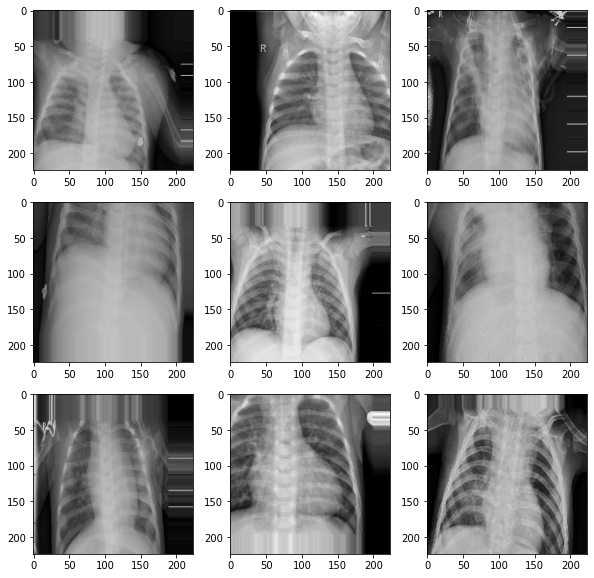

In [14]:
import copy 

# Visualizando data augmentation para 1 imagen
fig = plt.gcf()
fig.set_size_inches(10, 10)

it = copy.copy(train_data)

for i in range(9):
	plt.subplot(3, 3, 1 + i)
	batch = it.next()[0]
	imagenp = (batch[0]*255).astype('uint8')
	plt.imshow(imagenp)
 

### Confirm classes

In [15]:
train_data.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [16]:
train_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

### Check shape of image batches

In [17]:
# see the shape of the image batches
for image_batch, labels_batch in train_data:
    print('\nImage Shape: ')
    print(image_batch.shape)
    print(labels_batch.shape)
    break



Image Shape: 
(32, 224, 224, 3)
(32,)


The image_batch is a tensor of the shape (32, 224, 224, 3). 

This is a batch of 32 images of shape 224x224x3 (the last dimension refers to color channels RGB). 
The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.


### Calculate training steps and validation steps per epoch

In [18]:
# Calculate steps_per_epoch and validation_steps

# train images
train_samples = 5232
# validation_samples = 1045
test_samples = 624

def compute_steps_per_epoch(x):
    return int(math.ceil(1. * x / batch_size))

steps_per_epoch = compute_steps_per_epoch(train_samples)
val_steps = compute_steps_per_epoch(test_samples)
# test_steps = compute_steps_per_epoch(test_samples)
# see steps results
steps_per_epoch, val_steps


(164, 20)

# Modeling and Training

Create the base model from the VGG16 model.  This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes.  ImageNet is a research training dataset with a wide variety of categories images.  This base of knowledge will help us classify if a given X-ray image has pneumonia or not.

- First, we'll pick a layer of VGG16 to use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, we will follow the common practice to depend on the very last layer.  This layer is called the "bottleneck layer".  The bottleneck layer features retain more generality as compared to the top layer.

- Second, we'll instantiate a VGG16 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, we'll load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.


### Create the base model from the pre-trained convnets

In [19]:
# Create the base model from the pre-trained model


def get_model():
    '''load the base model from the pre-trained model VGG16.
       Load weights pre-trained on ImageNet.
       Do not include the ImageNet classifier at the top.
    '''  
    # load vgg16 pretrained model
    pretrained_model = VGG16(
        include_top=False,  
        weights='imagenet',
        input_shape=input_shape,
        classes=1000, 
        classifier_activation='softmax',
    )

    return pretrained_model


# get pretraind model
base_model = get_model()

# base model architecture
print("[INFO] Summary of the pretrained base model architecture.\n")
base_model.summary()


58892288/58889256 [==============================] - 0s 0us/step
[INFO] Summary of the pretrained base model architecture.

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___

We have **5 blocks** available to train. For the moment we have 0 non-trainable params but will add some when we do some feature extraction.


In [20]:
# check out the dense layer we'll connect to
base_model.output


<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

## Feature extraction

We'll freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, we'll add a classifier on top of it and train the top-level classifier.

- We utilize an existing pre-trained classifier as a starting point for a new classification.

- First, we will treat networks as arbitrary feature extractors.  
- Then, we'll use the representations learned by a previous network to extract meaningful features from new samples.  
- We'll add a new classifier, which will be trained from scratch, on top of the pretrained model so that we can repurpose the feature maps learned previously for the dataset.

Therefore. we do not need to retrain the entire model.  The base convolutional network already contains features that are generically useful for classifying pictures.  However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

When performing feature extraction, we treat the pre-trained network as an arbitrary feature extractor, allowing the input image to propagate forward, stopping at pre-specified layer, and taking the outputs of that layer as our features.


### Freeze the convolutional base

We'll add a classification head and compile the model.  When using Transfer learning via feature extraction it is important to freeze the convolutional base before we compile and train the model.

Freezing (*by setting layer.trainable = False*) prevents the weights in a given layer from being updated during training.


In [21]:
# loop over all layers in the base model and freeze them so they will
# not be updated during the first training process  
print("[INFO] Base model layers have been frozen...")
for layer in base_model.layers:
    layer.trainable = False


[INFO] Base model layers have been frozen...


In [22]:
# Let's confirm our layers are not trainable 
# Should be noted as False = Not trainable

for (i, layer) in enumerate(base_model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)


0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


## Add a classification head to the base model

This feature extractor converts each 224x224x3 image into a 7x7x512 block of features. Let's see what it does to an example batch of images:

In [23]:
image_batch, label_batch = next(iter(train_data))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 7, 7, 512)


To generate predictions from the block of features, average over the spatial 7x7 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 512-element vector per image.

In [24]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 512)


Also, we'll apply a tf.keras.layers.GlobalAverargePooling2D layer to convert these features into a single prediction per image.  

We don't need an activation function here because this prediction will be treated as a logit binary, or a raw prediction value.


## Construct a top model and compile the model

Here, we'll compile the model before training it.  Since we know there are two classes, we'll use a binary cross-entropy loss.  Also, we assume that y_pred encodes a probability distribution and the model provides a linear output.  Thus,  we'll use cross-entropy loss for binary (0 or 1) classification applications.

As well as, the label smoothing will produce a float betweein [0, 1]. 

If the float is greater than 0, then the label smoothing will squeeze them towards 0.5

That is, by using 1.0 - 0.5 * label_smoothing for the target class and 0.5 * label_smoothing for the non-target class.


In [25]:
# Construct a new model on top of base model


def head_model(metrics, output_bias=None):

    '''
    Instantiate a Sequential model without an input shape
    construct the head model that will be placed on top of the
    the base model.  We'll use dropout and then batch normalization 
    to prevent overfitting.
    '''
    model = Sequential(
        [  
            base_model,
            GlobalAveragePooling2D(),
            Dense(1024, activation='relu'),
            Dropout(0.3),
            BatchNormalization(),
            Dense(units=1, activation='sigmoid', name='prediction_layer'),
        ],
        
        name='Head_model'
    )
    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=metrics,
    )
    
    return model


# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = head_model(metrics)
print("[INFO] Getting Head model...")
print("[INFO] Classification head model has been compiled ...")
model.summary()


[INFO] Getting Head model...
[INFO] Classification head model has been compiled ...
Model: "Head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
prediction_layer (Dense)     (None, 1)                 1025      
Total params: 15,245,121
Trainable par

In [26]:
# how many trainable varibles we have
num_var = len(model.trainable_variables)
print("[INFO] There are", num_var , "trainable variables.")


[INFO] There are 6 trainable variables.


In [27]:
# show and save our base model architecture

!mkdir -p output/model_architecture

head_model_arch = plot_model(
    model,
    "output/model_architecture/tuned_model_architecture-01.png",
    show_shapes=True,
)


## Define Tuning Parameters and Callbacks


### Early stopping

Setting up an early stopping callbacks to avoid overfitting
and stop it if a validation accuracy is not maximized for 5 epochs.


In [28]:
# early stopping callback to prevent overfitting
early_stopping = EarlyStopping(
    # Stop training when `val_loss` is no longer improving
    monitor="val_loss",
    # no longer improving being defined as no better than 1e-2 less
    min_delta=1e-2,
    # no longer improving being further defined as for at least 5 epochs
    patience=5,
    mode='min',
    restore_best_weights=True,
    verbose=1,
)


### Model checkpoint

Create a model checkpoint to save weights of the model at frequent intervals.


In [29]:
# Create a ModelCheckpoint callback to save weights only during training
# Define the checkpoint directory to store the checkpoints
!mkdir -p output/checkpoint_dir

checkpoint_dir = "output/checkpoint_dir"

# Prepare a directory to store all the checkpoints.
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
# Define the name of the checkpoint files.
# checkpoint_prefix = os.path.join(checkpoint_dir, "mymodel_{epoch}")
checkpoint_prefix = os.path.join(checkpoint_dir, 'tuned_wts_model.hdf5')

# The two parameters below mean that we will overwrite
# the current checkpoint if and only if
# the `val_loss` score has improved.
# The saved model name will include the current epoch.
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_prefix,
    monitor='val_loss',
    mode='min',
    # Only save a model weigts if `val_loss` has improved.
    save_weights_only=True,
    verbose=1,
)


### Learning rate scheduler

In [30]:
# Define a function for decaying the learning rate
# This function keeps the initial learning rate for the first specified epochs
# and decreases it exponentially after that.

def scheduler(epoch, learning_rate):
    if epoch < 5:
        return learning_rate
    else:
        return learning_rate * tf.math.exp(-0.1)


### Callback for printing the learning rate

In [31]:
# Define a callback for printing the learning rate at the end of each epoch.

class PrintLR(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('\nLearning rate for epoch {} is {}'.format(
            epoch + 1, model.optimizer.lr.numpy()))


### Put all the callbacks together

In [32]:
# put all callbacks as list
callbacks = [
    early_stopping,
    model_checkpoint_callback,
    LearningRateScheduler(scheduler),
    PrintLR(),
]


### Estimate class weights for unbalanced datasets

Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

**Note**: Using class_weights changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers. The optimizer used here, tf.keras.optimizers.Adam, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [33]:
# Estimate class weights for unbalanced datasets
weights = compute_class_weight(
    'balanced',
    np.unique(train_data.classes),
    train_data.classes)

class_weight = dict(zip(np.unique(train_data.classes), weights))

print(class_weight)


{0: 1.939214232765011, 1: 0.6737058975019315}


The weight for class 0 (Normal) is a lot higher than the weight for class 1 (Pneumonia). Because there are less normal images, each normal image will be weighted more to balance the data as the CNN works best when the training data is balanced.


# Train the model

Train the model for 20 epochs using the training and validation data.

note:  The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data.

In [34]:
# build model and train it
print("[INFO] Training head model...")
start = datetime.now()

# train model
model_hist = model.fit(
    train_data,
    validation_data=test_data,
    validation_steps=val_steps,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1,
)

# get the training time
training_time = datetime.now() - start
print("Training completed in time: ", training_time)


[INFO] Training head model...
Epoch 1/20
164/164 [==============================] - 157s 945ms/step - loss: 0.4521 - accuracy: 0.7472 - auc: 0.8749 - prc: 0.9484 - val_loss: 0.4817 - val_accuracy: 0.8686 - val_auc: 0.9521 - val_prc: 0.9676

Epoch 00001: saving model to output/checkpoint_dir/tuned_wts_model.hdf5

Learning rate for epoch 1 is 9.999999747378752e-05
Epoch 2/20
164/164 [==============================] - 120s 734ms/step - loss: 0.2831 - accuracy: 0.8667 - auc: 0.9550 - prc: 0.9838 - val_loss: 0.3663 - val_accuracy: 0.8878 - val_auc: 0.9565 - val_prc: 0.9717

Epoch 00002: saving model to output/checkpoint_dir/tuned_wts_model.hdf5

Learning rate for epoch 2 is 9.999999747378752e-05
Epoch 3/20
164/164 [==============================] - 122s 743ms/step - loss: 0.2127 - accuracy: 0.9128 - auc: 0.9740 - prc: 0.9908 - val_loss: 0.2767 - val_accuracy: 0.9054 - val_auc: 0.9648 - val_prc: 0.9770

Epoch 00003: saving model to output/checkpoint_dir/tuned_wts_model.hdf5

Learning rate fo

### Check our checkpoint and logs directory

In [35]:
# Check the checkpoint directory.
!ls {checkpoint_dir}


tuned_wts_model.hdf5


### Save the entire model

In [36]:
# Save the entire model as a SavedModel.
!mkdir -p output/saved_model

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('output/saved_model/full_tuned_model-01.h5')


### Check our training history values

In [37]:
# put on a dataframe our model history values
hist_df = pd.DataFrame(data=model_hist.history)
hist_df


,loss,accuracy,auc,prc,val_loss,val_accuracy,val_auc,val_prc,lr
0,0.375598,0.804855,0.923550,0.971569,0.481679,0.868590,0.952082,0.967553,0.000100
1,0.257402,0.879014,0.962827,0.986827,0.366346,0.887821,0.956498,0.971742,0.000100
2,0.215305,0.909404,0.972434,0.990342,0.276740,0.905449,0.964793,0.977046,0.000100
3,0.197619,0.917049,0.975710,0.991583,0.233337,0.910256,0.973121,0.983150,0.000100
4,0.190271,0.920680,0.977309,0.991873,0.228153,0.911859,0.974326,0.984005,0.000100
5,0.179528,0.929281,0.979371,0.992281,0.265518,0.899038,0.974178,0.983914,0.000090
6,0.179108,0.925650,0.980209,0.993020,0.197069,0.923077,0.978337,0.986546,0.000082
7,0.176822,0.935015,0.979987,0.992971,0.246201,0.910256,0.976052,0.985198,0.000074
8,0.165241,0.935015,0.982423,0.993958,0.234019,0.908654,0.976835,0.985661,0.000067
9,0.159069,0.937309,0.984142,0.994582,0.214097,0.924679,0.976781,0.985648,0.000061


# Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the VGG16 base model as a fixed feature extractor.

In [38]:
def plot_curves(epochs, hist, list_of_metrics):
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10, 8))
   
    for n, metric in enumerate(list_of_metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 1, n+1)
         # plot metrics
        plt.plot(model_hist.epoch, model_hist.history[metric], label='train')
        plt.plot(model_hist.epoch, model_hist.history['val_' + metric], 
                 linestyle="--", label='val')
        
        plt.xlabel('Epoch')
        plt.ylabel(name)      
        plt.legend()
        
    
print("[INFO] Defined the plot_curve function.")


[INFO] Defined the plot_curve function.


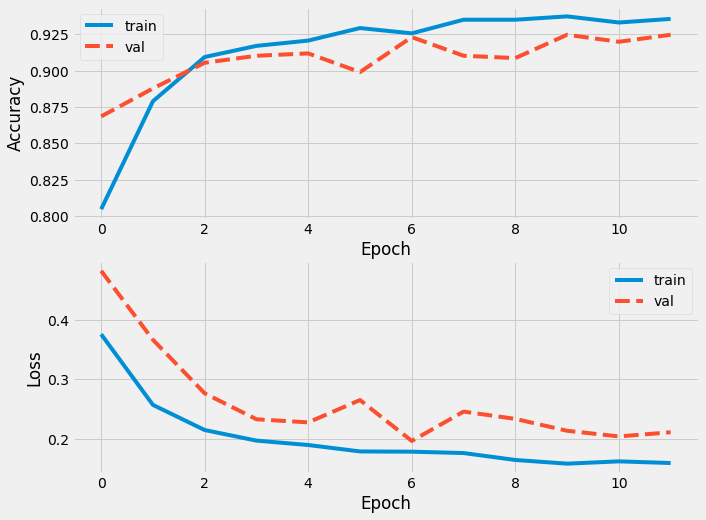

In [39]:
!mkdir -p output/plots

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy', 'loss'] 

plot_curves(epochs, model_hist, list_of_metrics_to_plot)


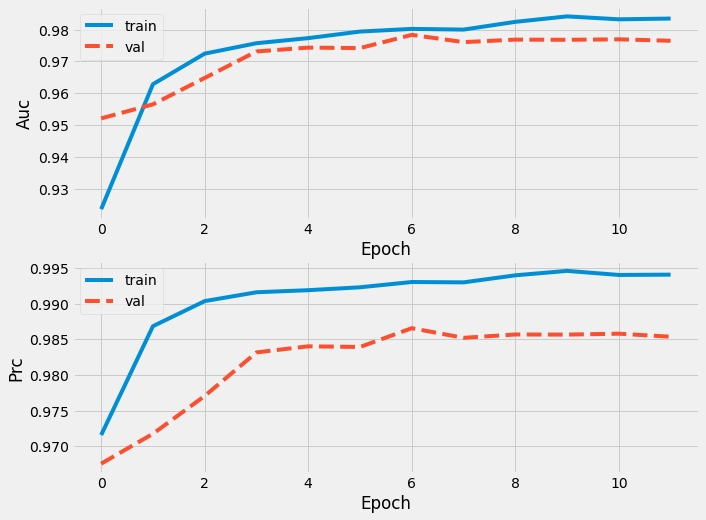

In [40]:
# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['auc', 'prc'] 

plot_curves(epochs, model_hist, list_of_metrics_to_plot)


# Evaluating model on test data

In [41]:
# reset our data generators
test_data.reset()
                 
# Evaluate the model on the test data using 'evaluate'
print("[INFO] Evaluate on test data...")
test_loss, test_accuracy, auc, prc = model.evaluate(
    test_data,
    steps=val_steps,
)

# round test_loss to 3 decimals and test accuracy to 2
test_loss = round(test_loss, 3)
test_accuracy = round(test_accuracy*100, 2)
auc = round(auc*100, 2)
prc = round(prc*100, 2)

# print model evaluation results
print('test loss: ', test_loss)
print('test acc:', test_accuracy)
print('test auc:', auc)
print('test prc: ', prc)


[INFO] Evaluate on test data...
20/20 [==============================] - 8s 375ms/step - loss: 0.1971 - accuracy: 0.9231 - auc: 0.9783 - prc: 0.9865
test loss:  0.197
test acc: 92.31
test auc: 97.83
test prc:  98.65


Accuracy alone doesn't tell the full story when you're working with a class-imbalanced data set, like this one, where there is a significant disparity between the number of normal and pneumonia labels.

Therefore, we'll look at two better metrics for evaluating class-imbalanced problems: precision and recall as well as sensitivity and specificity.


### Plot Probability Cut-off

20/20 [==============================] - 8s 397ms/step


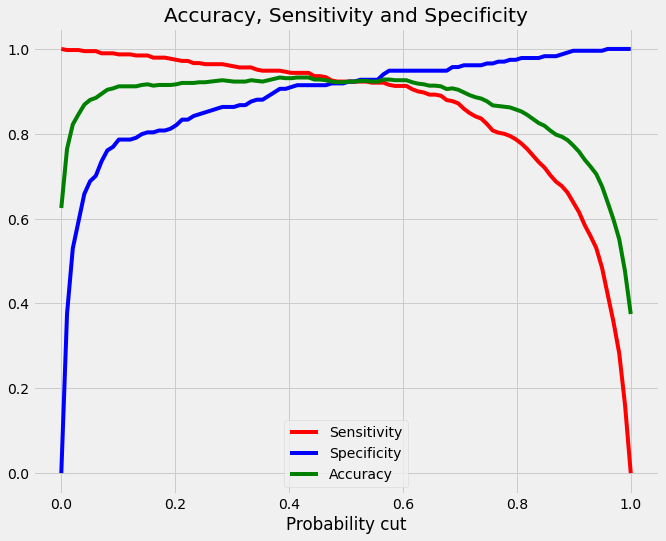

In [42]:
y_true = test_data.classes
y_prob = model.predict(test_data, batch_size=batch_size, verbose=1)

N = 100
cut = np.linspace(0., 1., N)
TPR = np.zeros(N)
TNR = np.zeros(N)
ACC = np.zeros(N)

for i in range(len(cut)):
    y_pred = np.round(y_prob - cut[i] + 0.5)
    CM = confusion_matrix(y_true, y_pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    TPR[i] = TP/(TP+FN)
    TNR[i] = TN/(TN+FP)
    ACC[i] = (TP+TN)/(TP+FP+FN+TN)

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 8))  
plt.plot(cut, TPR, c='red', label="Sensitivity")
plt.plot(cut, TNR, c='blue', label="Specificity")
plt.plot(cut, ACC, c='green', label="Accuracy")
plt.title("Accuracy, Sensitivity and Specificity")
plt.grid(True)
# plt.ylim(0.7, 1)
plt.xlabel("Probability cut")
plt.savefig('output/plots/acc_sensi_spec_curves', dpi=300)
plt.legend()
plt.show()


The ideal test is one that has both high sensitivity and high specificity, but the value of a test depends on the situation.

We need to determine a cut-off to minimize the cost of False positives and False negatives.   0.5 seems to be about alright.  Let's try it to see how our confusion matrix and classification report does.

# Classification Report

In [43]:
# set threshold of 0.5 if value > 0.5 == 1 if not 0
init_threshold = 0.5

# real predictions not between 0 and 1
Y_pred = model.predict(
    test_data, 
    batch_size=batch_size,
    verbose=1)

# getting values for our threshold
y_pred = np.where(Y_pred > init_threshold, 1, 0)
# print(y_pred[:10])
# print(y_pred_thresh[:10])


20/20 [==============================] - 8s 373ms/step


In [44]:
# print classification report
classification_report = classification_report(
    test_data.classes,
    y_pred,
    target_names=class_names,
)

print(classification_report)


              precision    recall  f1-score   support

      NORMAL       0.88      0.92      0.90       234
   PNEUMONIA       0.95      0.92      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.92      0.92       624
weighted avg       0.92      0.92      0.92       624



# Confusion Matrix

As we already know:

Let's make the following definitions:

- "Normal" is class 0.
- "Pneumonia" is class 1.

A true positive is an outcome where the model correctly predicts the positive class. Similarly, a true negative is an outcome where the model correctly predicts the negative class.

A false positive is an outcome where the model incorrectly predicts the positive class. And a false negative is an outcome where the model incorrectly predicts the negative class.


Normal cases correctly Detected - (True Negatives):  216
Pneumonia cases correctly Detected - (True Positives):  360
Normal cases incorrectly Detected - (False Positives):  18
Pneumonia cases incorrectly Detected -  (False Negatives):  30
Total Pneumonia cases:  390
Total Normal cases:  234




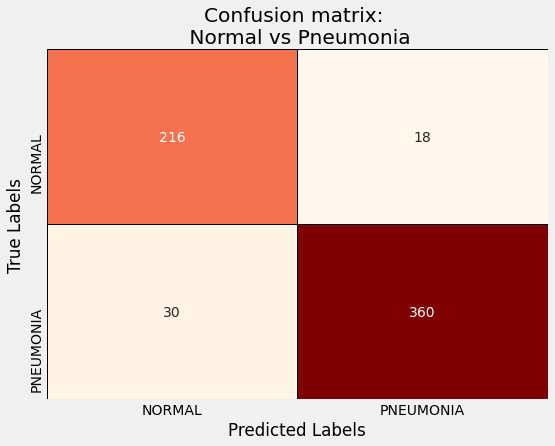

In [45]:
group_names = ['TN', 'FP', 'FN', 'TP']

cm = confusion_matrix(test_data.classes, y_pred)


def plot_matrix(cm):
    plt.figure(figsize=(8, 6))
    plt.title('Confusion matrix: \n Normal vs Pneumonia')
    heatmap = sns.heatmap(
            cm,
            cmap='OrRd',
            linecolor='black',
            linewidths=1,
            annot=True,
            cbar=False,
            fmt='',
            xticklabels=class_names,
            yticklabels=class_names
    )
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig('output/plots/tuned_confusion_matrix', dpi=300)

    return heatmap

plot_matrix(cm)
print('Normal cases correctly Detected - (True Negatives): ', cm[0][0])
print('Pneumonia cases correctly Detected - (True Positives): ', cm[1][1])
print('Normal cases incorrectly Detected - (False Positives): ', cm[0][1])
print('Pneumonia cases incorrectly Detected -  (False Negatives): ', cm[1][0])

print('Total Pneumonia cases: ', np.sum(cm[1]))
print('Total Normal cases: ', np.sum(cm[0]))
print('\n')
plt.show()


# AUC, Precision, Recall, Sensitivity and Specificity scores

Since we know that our data is imbalanced. Accuracy might not be the best model evaluation metric every time. It can convey the health of a model well only when all the classes have similar prevalence in the data. Thus, when the classes’ distribution is imbalanced, accuracy is not a good model evaluation metric. For this reason we will rely on Sensitivity and Specificity as well as AUC ROC Scores.

**Precision** attempts to answer the following question:

What proportion of positive identifications  was actually correct?

As well as, **Recall** attempts to answer the following question:

What proportion of actual positives was identified correctly?

**Note**:  improving precision typically reduces recall and vice versa

So depending on whether we want to detect all the positives (higher TPR) and willing to incur some error in terms of FPR, we need to decide the probability cut-off.


In [46]:
TN, FP, FN, TP = cm.ravel()

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = (TP) / (TP + FP)
recall = (TP) / (TP + FN)
sensitivity = (TP) / (TP + FN)
specificity = (TN) / (TN + FP)
prevalance = np.sum(test_data.classes) / len(test_data.classes)

print("accuracy: {:.2%}".format(accuracy))
print("precision: {:.2%}".format(precision))
print("recall: {:.2%}".format(recall))
print("sensitivity: {:.2%}".format(sensitivity))
print("specificity: {:.2%}".format(specificity))
print("prevalance: {:.2%}".format(prevalance))


accuracy: 92.31%
precision: 95.24%
recall: 92.31%
sensitivity: 92.31%
specificity: 92.31%
prevalance: 62.50%


We can determine that in 92.31% of the cases this model is predicting right for both cases.

That is why we won't rely on accuracy as an overall metric for this model. Although, accuracy is high, we could measure the sensitivity and specificity as a better metric for a medical diagnostic.

We have a prevalance of 62.50% because the proportion of normal cases is low.

The **Sensitivity** value indicates that out of 100 detections of pneumonia cases our model will predict the class 1 just about right in 92.31% of the time.  That is, out of 100 pneumonia cases approximately 92 cases will be predicted right and 9 pneumonia cases will be wrongly predicted as normal cases.

As well as, **Specificity** indicates that out of 100 normal cases detected approximataly 92 cases will be predicted right but it will missed 8 cases and will end up being predicted as pneumonia cases.  Not bad.

Our Precision seems to very high 95.24%.


## Plot AUC Curve

Now plot the ROC. This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

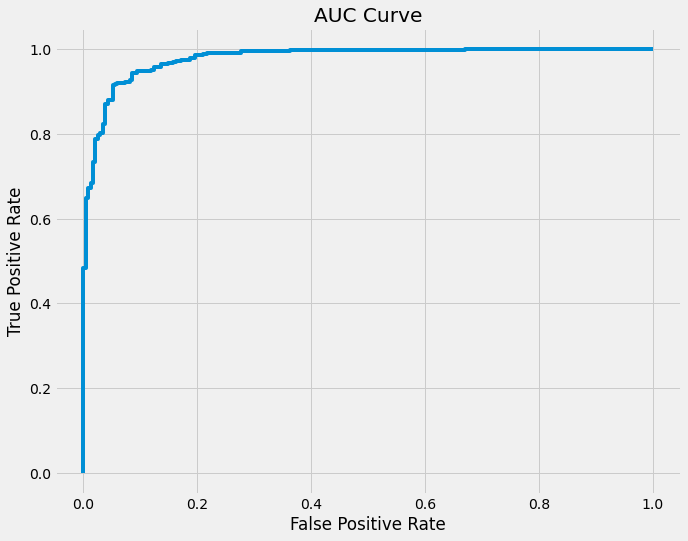


roc auc score: 97.83%


In [47]:
# The roc_curve() function computed the TPR and FPR for various threshold values.

y_pred = model.predict(test_data, batch_size=batch_size).ravel()
fpr, tpr, thresholds = roc_curve(test_data.classes , y_pred)

def plot_roc_curve(fpr, tpr): 
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr) 
    plt.title("AUC Curve")
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate')
    plt.savefig('output/plots/tuned_roc_curve-01', dpi=300)
    plt.show() 
    
    
plot_roc_curve(fpr,tpr)
auc_score = roc_auc_score(test_data.classes, y_pred)
print('\nroc auc score: {:.2%}'.format(auc_score))


# Predictions

image type:  <class 'PIL.Image.Image'>
image size:  (224, 224)


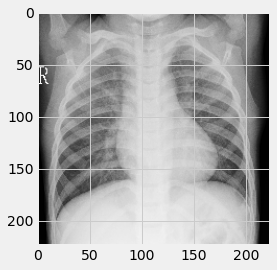

prediction output: 0.091525614
The X-RAY IMAGE belongs to a NORMAL person.

Predicition NORMAL
Prob: 9.15%


In [48]:
# image_path = 'test_images/BACTERIA.jpg'
image_path = '../input/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-1283091-0001.jpeg'

# load image in PIL format
image_to_predict = load_img(image_path, target_size=(224,224))
print('image type: ', type(image_to_predict))
print('image size: ', image_to_predict.size)
plt.imshow(image_to_predict)
plt.show()

# preprocess image
test_image = img_to_array(image_to_predict)
test_image = np.expand_dims(test_image, axis =0)
test_image = test_image.astype('float32')
test_image /=255

# prediction
output = model.predict(test_image)[0][0]
print('prediction output:' , output)

THRESHOLD = 0.5

prediction = 1 if (output > THRESHOLD) else 0

if prediction > THRESHOLD:
    print("The X-RAY IMAGE belongs to  a PNEUMONIA person.\n")
else:
    print("The X-RAY IMAGE belongs to a NORMAL person.\n")

CLASSES = ['NORMAL', 'PNEUMONIA']

ClassPred = CLASSES[prediction]
ClassProb = output

print("Predicition", ClassPred)
print("Prob: {:.2%}".format(ClassProb))


# References 

[Transfer learning and fine-tuning - tensorflow tutorials](https://www.tensorflow.org/tutorials/images/transfer_learning)

[Fine tuning with Keras and Deep Learning - tutorial](https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/)

[writing your own callbacks - tensorflow tutorials](https://www.tensorflow.org/guide/keras/custom_callback#setup)

[Data Augmentation in Medical Images](https://towardsdatascience.com/data-augmentation-in-medical-images-95c774e6eaae)

[How to select Performance Metrics for Classification Models](https://medium.com/analytics-vidhya/how-to-select-performance-metrics-for-classification-models-c847fe6b1ea3)
